In [3]:
import numpy as np
import networkx as nx
import scipy as sp
from pathlib import Path
from scipy import sparse
import matplotlib.pyplot as plt
import graph_tool.all as gt
import glob
import pandas as pd
import os
from scipy import linalg
from scipy.sparse import coo_array
import time
from matplotlib.colors import to_hex
import matplotlib
import sys
import warnings
import random
import re
warnings.filterwarnings("ignore")
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')

def get_sorted_filenames(directory):
    # List all files in the given directory
    filenames = os.listdir(directory)

    # Remove file extensions and convert numbers to integers
    processed_filenames = []
    for filename in filenames:
        # Remove the file extension
        name_without_extension = os.path.splitext(filename)[0]
        
        # Extract numbers and convert them to integers
        parts = re.split('(\d+)', name_without_extension)
        parts = [int(part) if part.isdigit() else part for part in parts]
        
        processed_filenames.append(parts)

    # Sort filenames based on the processed parts
    processed_filenames.sort()

    # Join the parts back into strings
    sorted_filenames = [''.join(map(str, parts)) for parts in processed_filenames]
    
    return sorted_filenames

def custom_mean(x):
    # Fill NaN with 0 for calculation
    x_filled = x.fillna(0)
    
    # If sum is 0, return NaN
    if x_filled.sum() == 0:
        return np.nan
    
    # Calculate mean over all seeds (including NaN positions treated as 0)
    return x_filled.sum() / len(x)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Compiler/gcc9/graph-tool/2.56/lib/python3.10/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [5]:
'''
Figure 1 with extended c, d
LTM plotings 4*4 spectrum and LTM
'''
import matplotlib
matplotlib.use('Agg')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset




n = 1000
k = 16
cas = 0.3
save = True

model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'ws'
network = network_class

pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')




g = {'param1':[],'param2':[],'th':[]}
# network_corr = pd.DataFrame(data=g)
# network_corr.set_index(['param1','param2','th'],inplace=True)
methods = ['pearson','spearman']

fig,axs = plt.subplots(figsize=(5.5*1.5,2.31*2),ncols=2,nrows=2,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


# Keep your original creation lines untouched:
# fig,axs = plt.subplots(..., tight_layout=True)
# fig.subplots_adjust(...)

# --- BEGIN: bottom-row widening + centering + gap (top row untouched) ---
# Capture original bottom axes positions
pos10 = axs[1, 0].get_position()
pos11 = axs[1, 1].get_position()

# Parameters
scale = 1.20  # 30% wider per bottom axis; adjust as needed
gap   = 0.11  # desired horizontal gap BETWEEN bottom axes in figure fraction; adjust as needed

def _make_wider_centered_with_gap(pos_left, pos_right, scale, gap, right_limit=0.98, left_limit=0.02):
    """
    Given the original positions of the left and right bottom axes (in figure fraction),
    return two new [x0, y0, w, h] lists after:
      1) widening each by `scale`,
      2) keeping each centered around its original center,
      3) enforcing a target gap between them,
      4) clamping to figure bounds if needed.

    left_limit/right_limit define safe margins to avoid touching edges.
    """
    # Original centers and widths
    cL = pos_left.x0 + pos_left.width  * 0.5
    cR = pos_right.x0 + pos_right.width * 0.5
    wL_new = pos_left.width  * scale
    wR_new = pos_right.width * scale
    hL, hR = pos_left.height, pos_right.height
    yL, yR = pos_left.y0, pos_right.y0

    # Start by keeping them centered on their original centers
    xL = cL - wL_new * 0.5
    xR = cR - wR_new * 0.5

    # Current gap (space between right edge of left axis and left edge of right axis)
    current_gap = (xR) - (xL + wL_new)
    delta = gap - current_gap

    # Adjust positions symmetrically to achieve the target gap
    xL -= delta / 2.0
    xR += delta / 2.0

    # Optional: clamp within figure limits to avoid overflow
    # Clamp left axis
    if xL < left_limit:
        shift = left_limit - xL
        xL += shift
        xR += shift  # move both together to keep the enforced gap

    # Clamp right axis
    if xR + wR_new > right_limit:
        shift = (xR + wR_new) - right_limit
        xL -= shift
        xR -= shift

        # If clamping pushed left axis beyond left_limit, re-clamp left and accept smaller gap if necessary
        if xL < left_limit:
            xL = left_limit
            # Re-place right axis to maintain as much of the gap as possible within limits
            xR = max(xL + wL_new + gap, xL + wL_new + 0.0)
            # Final clamp on the right axis if still overflowing
            if xR + wR_new > right_limit:
                xR = right_limit - wR_new  # accept reduced gap

    return [xL, yL, wL_new, hL], [xR, yR, wR_new, hR]

# Compute new positions
new_pos10, new_pos11 = _make_wider_centered_with_gap(pos10, pos11, scale=scale, gap=gap)

# Remove and recreate bottom axes with new positions
axs[1, 0].remove()
axs[1, 0] = fig.add_axes(new_pos10)

axs[1, 1].remove()
axs[1, 1] = fig.add_axes(new_pos11)
# --- END: bottom-row widening + centering + gap ---


axins = inset_axes(axs[1,0], width="30%", height="30%", loc='upper right')

flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0][0].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
    # if len(l_label) > 3:
    #     l_label = l_label[:3]
    #     flag_l_label=1
    # # print(len(l_label))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0][0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
        axs[1][0].hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label)
        axins.hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label)
    elif idx < 8:
        axs[0][0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
        axs[1][0].hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label,color='black')
        axins.hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label,color='black')
    elif idx < 12:
        axs[0][0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[0][0].set_yscale('log')
axs[0][0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0][0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0][0].set_ylim([3*10**-5,1.12])
axs[0][0].set_xlim([-0.02,0.52])
axs[0][0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0][0].tick_params(axis='x',labelsize=7)
axs[0][0].tick_params(axis='y',labelsize=7)
axins.set_xlim(-0.02, 0.62)
axins.set_ylim(0, 1)
# axins.set_ylabel(r'Density',labelpad=-8,fontsize=3,)
# axins.set_xlabel(r'Normalized Eigenvalues',labelpad=-5,fontsize=3,math_fontfamily='cm')
axins.set_xticks([0.0,0.2,0.4,0.6])
axins.set_yticks([0,0.5,1])
axins.tick_params(axis='x',labelsize=5)
axins.tick_params(axis='y',labelsize=5)
axs[1,0].indicate_inset_zoom(axins, edgecolor="black")
## Legend and title
legend0 = axs[0][0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend0.get_title().set_position((1.5,0))
legend0.get_title().set_fontsize('7')

axs[0,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[0,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'mhk'
network = network_class

nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)



axins = inset_axes(axs[1,1], width="30%", height="30%", loc='upper right')
# x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])





flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0][1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0][1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
        axs[1][1].hist(eig_lap, bins=100, density=True, alpha=0.5)
        axins.hist(eig_lap, bins=100, density=True, alpha=0.5)
    elif idx < 8:
        axs[0][1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)
        axs[1][1].hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label,color='black')
        axins.hist(eig_lap, bins=100, density=True, alpha=0.5,label=pol_fig_legend_label,color='black')
    elif idx < 12:
        axs[1][1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff



axs[0][1].set_yscale('log')
axs[0][1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0][1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0][1].set_ylim([3*10**-5,1.12])
axs[0][1].set_xlim([-0.02,0.52])
axs[0][1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0][1].tick_params(axis='x',labelsize=7)
axs[0][1].tick_params(axis='y',labelsize=7)

axins.set_xlim(-0.02, 0.62)
axins.set_ylim(0, 1)
# axins.set_ylabel(r'Density',labelpad=-8,fontsize=3,)
# axins.set_xlabel(r'Normalized Eigenvalues',labelpad=-5,fontsize=3,math_fontfamily='cm')
axins.set_xticks([0.0,0.2,0.4,0.6])
axins.set_yticks([0,0.5,1])
axins.tick_params(axis='x',labelsize=5)
axins.tick_params(axis='y',labelsize=5)
axs[1,1].indicate_inset_zoom(axins, edgecolor="black")
## Legend and title
legend1 = axs[0][1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[0,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[0,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


# for ax in axs:
#     ax.text(0.055,0.9,r'{\fontfamily{phv}\selectfont  \textbf{Simple}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
#     ax.text(0.69,0.9,r'{\fontfamily{phv}\selectfont   \textbf{Complex}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
axs[0][0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0][0].transAxes,fontsize=8)
axs[0][1].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[0][1].transAxes,fontsize=8)
axs[1][0].text(-0.02,1.03,r'\textbf{(c)}',transform=axs[1][0].transAxes,fontsize=8)
axs[1][1].text(-0.02,1.03,r'\textbf{(d)}',transform=axs[1][1].transAxes,fontsize=8)

axs[1][0].set_ylabel(r'Density',labelpad=2.5)
axs[1][0].set_xlabel(r'Normalized Laplacian Eigenvalues',labelpad=2,math_fontfamily='cm')
axs[1][0].set_ylim([0,6.8])
axs[1][0].set_xlim([-0.02,2.05])
axs[1][0].set_xticks([0,0.5,1,1.5,2])
axs[1][0].tick_params(axis='x',labelsize=7)
axs[1][0].tick_params(axis='y',labelsize=7)


axs[1][1].set_ylabel(r'Density',labelpad=2.5)
axs[1][1].set_xlabel(r'Normalized Laplacian Eigenvalues',labelpad=2,math_fontfamily='cm')
axs[1][1].set_ylim([0,6.8])
axs[1][1].set_xlim([-0.02,2.05])
axs[1][1].set_xticks([0,0.5,1,1.5,2])
axs[1][1].tick_params(axis='x',labelsize=7)
axs[1][1].tick_params(axis='y',labelsize=7)

axs[0][0].grid(True, which="major", ls=":")
axs[0][1].grid(True, which="major", ls=":")


if save:
    fig_path = f'figs'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'/Figure_1.pdf')
    plt.draw()
    plt.show()
    print('fig saved')
else:
    fig.show()

plotting
Cascade size 0.3
Cascade size 0.3
fig saved


16/240/top/5/ws
Loading data ..,
Getting correlations ..,
Plotting ..,
networks/LFC/240/ws/16/1723491427597.gt
networks/LFC/240/ws/16/1723491425263.gt
networks/LFC/240/ws/16/1723491423811.gt
networks/LFC/240/ws/16/1723491423382.gt


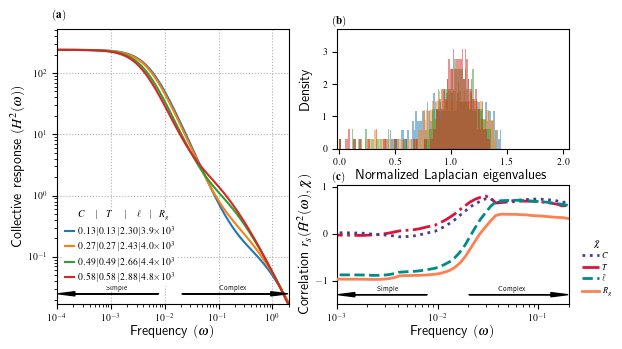

Figure_2
figs/Figure_2.pdf
pdf file saved


In [6]:
'''
Figure 2
LFC Plotting
MHK + WS
Gain, Spectrums, Correlations
Figures 2-3
'''

def LFC_plot(net,Ks,t_b,perc,model = 'LFC', centrality = 'degree', output = None):
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
    # matplotlib.verbose.level = 'debug-annoying'
    for in_k in Ks:
        ix=pd.IndexSlice
        intended_k = in_k
        networks = [net]
        nodes = 240
        degrees = range(2,33,2) 
        print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')

        print('Loading data ..,')


        d = {'ID':[],'freq':[],'p':[]}
        network_gains = pd.DataFrame(data=d)
        network_gains.set_index(['ID','freq','p'],inplace=True)

        e = {'ID':[],'p':[]}
        network_props = pd.DataFrame(data=e)
        network_props.set_index(['ID','p'],inplace=True)

        insert = True
        landscape = True

        # main_props = ['CC','SP','Rg']
        main_props = ['CC','T','SP','Rg']
        aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
        props = main_props + aux_props
        # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
        prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}
        for network in networks:
            for k in degrees:
                # print(k)
                # new_network_gains = pd.read_csv(f'networks_new/{nodes}/{k}/{network}_corr_gains.csv',sep='\t',index_col=[1])
                # new_props = pd.read_csv(f'networks_new/{nodes}/{k}/{network}_props.csv',sep='\t',index_col=[0,1])

                new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
                new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])

                new_props['p'] = new_props.index.get_level_values(1)

                new_props['k'] = k
                new_props['rawCC'] = new_props.CC
                new_props['rawSP'] = new_props.SP
                new_props['rawRg'] = new_props.Rg
                new_props['rawT'] = new_props['T']
                new_props.CC = new_props.CC/new_props.CC.max()
                new_props['T'] = new_props['T']/new_props['T'].max()
                new_props.Rg = new_props.Rg/new_props.Rg.min()
                new_props.SP = new_props.SP/new_props.SP.min()

                for f in new_network_gains.index.unique():
                    new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


                if 'k' in new_network_gains.columns:
                    new_network_gains.loc[network_gains.isnull().k,'k']=k
                else:
                    new_network_gains['k'] = k

                network_props = pd.concat([network_props, new_props.loc[:,props]])
                # network_props = network_props.append(new_props.loc[:,props])

                new_network_gains = new_network_gains.reset_index()
                new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

                new_network_gains.set_index(['ID','freq'],inplace=True)

                # network_gains = network_gains.append(new_network_gains)
                network_gains = pd.concat([network_gains, new_network_gains])

        network_props.fillna(value=0,inplace = True)
        network_gains.fillna(value=0,inplace = True)

        print('Getting correlations ..,')
        freq16 = network_gains.index.get_level_values(1).unique()
        freqAll = network_gains.loc[network_gains.k==[x for x in degrees if x != intended_k][0]].index.get_level_values(1).unique()

        gg = pd.MultiIndex.from_tuples(list(zip(main_props*len(freqAll),['H2']*len(freqAll)*len(main_props),sorted(list(freqAll)*len(main_props)))))
        corr_index_k = pd.MultiIndex.from_tuples(list(zip(main_props*len(freq16),['H2']*len(freq16)*len(main_props),sorted(list(freq16)*len(main_props)))))
        network_corr_k = pd.DataFrame(index=corr_index_k)
        network_corr_lim = pd.DataFrame(index=gg)

        correlations = ['spearman']

        max_sp_lim = network_props.SP.max()
        min_sp_lim = network_props.SP.min()

        max_cc_lim = network_props.CC.max()
        min_cc_lim = network_props.CC.min()

        max_rg = network_props.Rg.max()
        min_rg = network_props.Rg.min()

        if network == 'mhk':
            specialp = [20,85,97,99] #k = 16 [0.14,0.27,0.50,0.175]
            min_rg = 1.2
            max_rg = 2.2
            min_cc_lim = 0.6
            max_cc_lim = 1
        elif network == 'ws':
            min_cc_lim = 0.6
            max_cc_lim = 1
            min_rg = 1.2
            max_rg = 2.2
            specialp = [51,30,12,7]

        elif network == 'ke':
            specialp = [20,90,97,99]

        # network_props.query(f'{min_cc_lim} < CC < {max_cc_lim} and {min_sp_lim}  < SP < {max_sp_lim} and {min_rg} < Rg < {max_rg}').loc[:,('CC','SP','Rg')].corr(method='spearman').round(2)

        # query for  range of clutsering
        query_string = f'{min_cc_lim} < CC < {max_cc_lim} and {min_sp_lim} < SP < {max_sp_lim} and {min_rg} < Rg < {max_rg}'
        # query_string16 = f'k == {intended_k}'

        # lim_IDs = network_props.query(query_string).index.get_level_values(0)
        # temp_network_ins = network_gains.loc[ix[lim_IDs,:]]
        # corr_values_k = []
        corr_values_lim = []
        for coef in correlations:
            # ## Need to be sorted, because network_corr_... expects frequencies to be ordered
            # for f in freq16.sort_values():
            #     corr_values_k += list(network_props.query(query_string16).loc[:,main_props].corrwith(network_gains.loc[ix[:,f],'H2'],method=coef).values)

            for f in freqAll.sort_values():
                corr_values_lim += list(network_props.query(query_string).loc[:,main_props].corrwith(network_gains.loc[ix[:,f],'normH2'],method=coef).values)

        # network_corr_k.loc[corr_index_k,coef] = np.reshape(corr_values_k,(len(corr_values_k),1))
        network_corr_lim.loc[gg,coef] = np.reshape(corr_values_lim,(len(corr_values_lim),1))

        print(f'Plotting ..,')

        my_new_colors = ['darkslateblue','crimson','darkcyan','coral']


        fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7),ncols=2,nrows=2,sharex=False,sharey=False)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.21, hspace=0.3)
        ## Getting correct plot setup
        gs = axs[0][0].get_gridspec()
        axs[0][0].remove()
        axs[1][0].remove()
        bigax = fig.add_subplot(gs[0:,0])

        ax_eig = axs[0][1]
        ax_corr = axs[1][1]

        ## Formating collective frequency response
        bigax.set_xscale('log')
        bigax.set_yscale('log')
        bigax.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
        bigax.set_ylabel(r'Collective response $(H^2(\omega))$',labelpad=2.5)



        specialk = intended_k
        directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
        sorted_filenames = get_sorted_filenames(directory_path)

        network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
        prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
        gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
        for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
            flag_l_label = 0

            C_label = str(prop_special.loc[p].rawCC.round(2))
            if len(C_label) < 4:
                C_label =  C_label + '0'
            l_label = str(prop_special.loc[p].rawSP.round(2))

            if len(l_label) < 5:
                flag_l_label=1

            r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
            # if len(r_label) > 3:
            #     r_label = r_label[:2]
            r_label = r_label + r'\! \times \! 10^{3}'

            if flag_l_label:
                label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'

            pol_fig_legend_label = label_string 

            G = gt.load_graph(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
            print(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
            eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())

            bigax.plot(gain_special.loc[p].H2,label=label_string)
            ax_eig.hist(eig_lap, bins=100, density=True, alpha=0.5)

        leg1 = bigax.legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\ \ell   \,\;\,\ | \;\,\,\;\, R_{g} $', loc=[0.025,0.07],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)

        leg1.get_title().set_position((3.55, 0))
        leg1.get_title().set_fontsize('7')
        leg1.get_frame().set_facecolor('white')
        leg1.get_frame().set_alpha(1.0)
        leg1.get_frame().set_edgecolor('white')

        for idx,metric in enumerate(main_props):
            ax_corr.plot(network_corr_lim.loc[(metric,'H2')],label=prop_label[metric],zorder=[3,2,4,3,5][idx%5],c=my_new_colors[idx%5],linewidth=2,markersize=[5,5,5,5][idx%5],ls=[':', '-.', '--', 'solid'][idx%5],markeredgewidth=[1,1,1,1][idx%4],markerfacecolor='none')


        leg2=ax_corr.legend(title=r'$\bar{\chi}$',loc=[1.05,0.05],borderpad=0.2,markerscale=1,handlelength=2,handletextpad=0.4,fontsize=6)
        leg2.get_title().set_position((0, 0))
        leg2.get_title().set_fontsize('7')
        leg2.get_frame().set_facecolor('white')
        leg2.get_frame().set_alpha(1.0)
        leg2.get_frame().set_edgecolor('white')
        
        ## Setup axises
        


        ax_eig.set_ylabel(r'Density',labelpad=8)
        ax_eig.set_xlabel(r'Normalized Laplacian eigenvalues',labelpad=2,math_fontfamily='cm')
        ax_eig.set_ylim([0,3.7])
        ax_eig.set_xlim([-0.02,2.05])

        
        # ax_corr.set_ylabel(r'Correlation $r_s$',labelpad=2.5)
        ax_corr.set_ylabel(r'Correlation $r_s(\bar{H}^2(\omega),\bar{\chi})$',labelpad=2.5)
        ax_corr.set_xscale('log')
        ax_corr.set_xlabel(r'Frequency $( \omega )$',labelpad=2, math_fontfamily='cm')

        ## Set axis limits
        bigax.set_xlim([0.0001,2])
        bigax.set_ylim([0.017,520])

        ax_corr.set_ylim([-1.5,1.05])
        ax_corr.set_xlim([0.001,0.2])

        ## Title



        ## Indentifying letters
        bigax.text(-0.02,1.04,r'$\bf{(a)}$',transform=bigax.transAxes,fontsize=8)
        ax_eig.text(-0.02,1.04,r'$\bf{(b)}$',transform=ax_eig.transAxes,fontsize=8)
        ax_corr.text(-0.02,1.04,r'$\bf{(c)}$',transform=ax_corr.transAxes,fontsize=8)

        ax_corr.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([-1,0,1]))

        ax_corr.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())

        ## text boxes
        box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)
        bigax.grid(True, which="major", ls=":")
        ax_eig.grid(False)
        ax_corr.grid(False)

        bigax.tick_params(axis='x',labelsize=7)
        ax_eig.tick_params(axis='x',labelsize=7)
        ax_corr.tick_params(axis='x',labelsize=7)
        bigax.tick_params(axis='y',labelsize=7)
        ax_eig.tick_params(axis='y',labelsize=7)
        ax_corr.tick_params(axis='y',labelsize=7)

        ax_corr.fill_between(x=[0.015,2.9],y1=[-4,-4],y2=[-1.72,-1.72],facecolor='w',zorder=-10)


        bigax.annotate(
            '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        bigax.annotate(
            '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        # Add text on the right saying "complex"
        bigax.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
        bigax.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')




        ax_corr.annotate(
            '', xy=(10**-3, -1.3), xytext=(8*10**-3, -1.3),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        ax_corr.annotate(
            '', xy=(0.2, -1.3), xytext=(2*10**-2, -1.3),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        # Add text on the right saying "complex"
        ax_corr.text(2.5*10**-3, -1.2, 'Simple', fontsize=5, verticalalignment='center')
        ax_corr.text(4*10**-2, -1.2, 'Complex', fontsize=5, verticalalignment='center')


        plt.show()
        print(output)
        fig_path = f"figs"
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(f'{fig_path}/{output}.pdf')
        print(f'{fig_path}/{output}.pdf')
    return print('pdf file saved')


# model = 'LFC'
ks = [16]
for net in ['ws']:
    for t_b in ['top']:
        perc = int(5)
        LFC_plot(net,ks,t_b,perc,model = 'LFC', centrality = 'degree', output = "Figure_2")

16/240/top/5/mhk
Loading data ..,
Getting correlations ..,
Plotting ..,
networks/LFC/240/mhk/16/1723490982124.gt
networks/LFC/240/mhk/16/1723491002607.gt
networks/LFC/240/mhk/16/1723491004798.gt
networks/LFC/240/mhk/16/1723491005097.gt


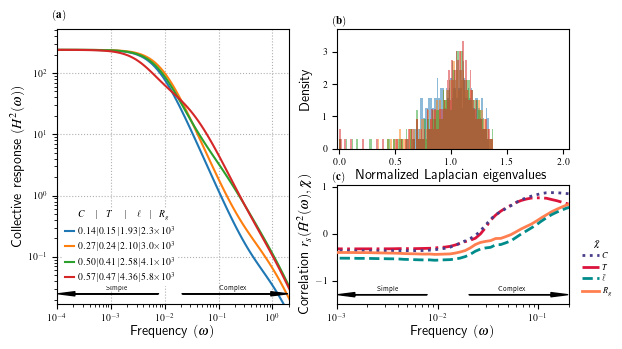

Figure_3
figs/Figure_3.pdf
pdf file saved


In [7]:
'''
Figure 3
'''
ks = [16]
for net in ['mhk']:
    for t_b in ['top']:
        perc = int(5)
        LFC_plot(net,ks,t_b,perc,model = 'LFC', centrality = 'degree', output = "Figure_3")

In [8]:
'''
Figure 4
LTM mhk top bottom 5%
LTM plotings 1*2 to show hub and non-hub
'''
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


n = 1000
k = 16
cas = 0.3

model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'mhk'
network = network_class


save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65],'ke':[0,10,30,20]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file = f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')


g = {'param1':[],'param2':[],'th':[]}
# network_corr = pd.DataFrame(data=g)
# network_corr.set_index(['param1','param2','th'],inplace=True)
methods = ['pearson','spearman']

fig,axs = plt.subplots(figsize=(5.5*1.25,2.31),ncols=2,nrows=1,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))

    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[0].set_yscale('log')
axs[0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0].set_ylim([3*10**-5,1])
axs[0].set_xlim([-0.02,0.52])
axs[0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0].tick_params(axis='x',labelsize=7)
axs[0].tick_params(axis='y',labelsize=7)
## Legend and title
# legend0 = axs[0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
# legend0.get_title().set_position((1.5,0))
# legend0.get_title().set_fontsize('7')

axs[0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


network_root = f'bot{-int(n/20)}'


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c = 'black')
    elif idx < 12:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff

axs[1].set_yscale('log')
axs[1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1].set_ylim([3*10**-5,1])
axs[1].set_xlim([-0.02,0.52])
axs[1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1].tick_params(axis='x',labelsize=7)
axs[1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


axs[0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0].transAxes,fontsize=8)
axs[1].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[1].transAxes,fontsize=8)

axs[0].grid(True, which="major", ls=":")
axs[1].grid(True, which="major", ls=":")


if save:
    fig_path = f'figs/'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'Figure_4.pdf')
    print('fig saved')
else:
    fig.show()

plotting
Cascade size 0.3
Cascade size 0.3
fig saved


Loading data ..,
16/240/top/5/ws
Plotting ..,
networks/LFC/240/ws/16/1723491427597.gt
networks/LFC/240/ws/16/1723491425263.gt
networks/LFC/240/ws/16/1723491423811.gt
networks/LFC/240/ws/16/1723491423382.gt
16/240/bot/5/ws


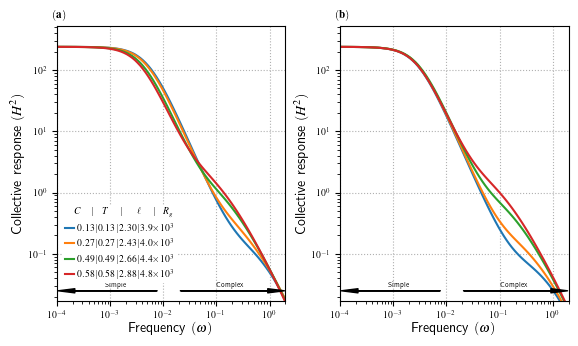

figs/ws_16_top_bot_5_LFC_degree.pdf


In [14]:
'''
Figure 5
LFC Plotting
top-bottom
Side-by-Side for one k and one network [top---bot]
'''


save = True
model = 'LFC'
net = 'ws' #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
Ks  = [16]
centrality = 'degree'
# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'
for in_k in Ks:
    t_b = 'top'
    ix=pd.IndexSlice
    intended_k = in_k
    networks = [net]
    network = net
    nodes = 240
    
    print('Loading data ..,')

    d = {'ID':[],'freq':[],'p':[]}
    network_gains = pd.DataFrame(data=d)
    network_gains.set_index(['ID','freq','p'],inplace=True)

    e = {'ID':[],'p':[]}
    network_props = pd.DataFrame(data=e)
    network_props.set_index(['ID','p'],inplace=True)

    insert = True
    landscape = True

    # main_props = ['CC','SP','Rg']
    main_props = ['CC','T','SP','Rg']
    aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
    props = main_props + aux_props
    # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
    prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}

    
    
    print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
    k = in_k
    new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
    new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])

    new_props['p'] = new_props.index.get_level_values(1)

    new_props['k'] = k
    new_props['rawCC'] = new_props.CC
    new_props['rawSP'] = new_props.SP
    new_props['rawRg'] = new_props.Rg
    new_props['rawT'] = new_props['T']
    new_props.CC = new_props.CC/new_props.CC.max()
    new_props['T'] = new_props['T']/new_props['T'].max()
    new_props.Rg = new_props.Rg/new_props.Rg.min()
    new_props.SP = new_props.SP/new_props.SP.min()

    for f in new_network_gains.index.unique():
        new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


    if 'k' in new_network_gains.columns:
        new_network_gains.loc[network_gains.isnull().k,'k']=k
    else:
        new_network_gains['k'] = k

        network_props = pd.concat([network_props, new_props.loc[:,props]])
        # network_props = network_props.append(new_props.loc[:,props])

        new_network_gains = new_network_gains.reset_index()
        new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

        new_network_gains.set_index(['ID','freq'],inplace=True)

        # network_gains = network_gains.append(new_network_gains)
        network_gains = pd.concat([network_gains, new_network_gains])

    network_props.fillna(value=0,inplace = True)
    network_gains.fillna(value=0,inplace = True)


    if network == 'mhk':
        specialp = [20,85,97,99] #k = 16 [0.14,0.27,0.50,0.175]

    elif network == 'ws':
        specialp = [51,30,12,7]
    elif network == 'ke':
        specialp = [20,90,97,99]

    print(f'Plotting ..,')

    my_new_colors = ['darkslateblue','darkcyan','coral','blue']
    
    fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7),ncols=2,nrows=1,sharex=False,sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.3)
    ## Getting correct plot setup
    gs = axs[0].get_gridspec()
    axs[0].remove()
    bigax = fig.add_subplot(gs[0:,0])

    bigax2 = axs[1]

    ## Formating collective frequency response
    bigax.set_xscale('log')
    bigax.set_yscale('log')
    bigax.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
    bigax.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)
    
    bigax2.set_xscale('log')
    bigax2.set_yscale('log')
    bigax2.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
    bigax2.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)


    specialk = intended_k
    # networks/{model}/{nodes}/{network}/{k}_props.csv
    directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
    sorted_filenames = get_sorted_filenames(directory_path)

    network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
    prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
    gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
    for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
        flag_l_label = 0

        C_label = str(prop_special.loc[p].rawCC.round(2))
        if len(C_label) < 4:
            C_label =  C_label + '0'
        l_label = str(prop_special.loc[p].rawSP.round(2))

        if len(l_label) < 5:
            flag_l_label=1

        r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
        # if len(r_label) > 3:
        #     r_label = r_label[:2]
        r_label = r_label + r'\! \times \! 10^{3}'


        if flag_l_label:
            label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
        # else:
        #     label_string =fr'${C_label}  |  {prop_special.loc[p].rawSP:.2f} \, |  {r_label}  \, |  {prop_special.loc[p][3]:.2f}$'

        pol_fig_legend_label = label_string 
        # print(network,p,intended_k)


        G = gt.load_graph(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
        print(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
        eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())

        bigax.plot(gain_special.loc[p].H2,label=label_string)

    
    t_b = 'bot'
    
    d = {'ID':[],'freq':[],'p':[]}
    network_gains = pd.DataFrame(data=d)
    network_gains.set_index(['ID','freq','p'],inplace=True)
    
    print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
    k = in_k
    new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])

    for f in new_network_gains.index.unique():
        new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


    if 'k' in new_network_gains.columns:
        new_network_gains.loc[network_gains.isnull().k,'k']=k
    else:
        new_network_gains['k'] = k

        network_props = pd.concat([network_props, new_props.loc[:,props]])
        # network_props = network_props.append(new_props.loc[:,props])

        new_network_gains = new_network_gains.reset_index()
        new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

        new_network_gains.set_index(['ID','freq'],inplace=True)

        # network_gains = network_gains.append(new_network_gains)
        network_gains = pd.concat([network_gains, new_network_gains])

    network_props.fillna(value=0,inplace = True)
    network_gains.fillna(value=0,inplace = True)

    network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
    prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
    gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
    for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
        bigax2.plot(gain_special.loc[p].H2 ,label=label_string)

          

    leg1 = bigax.legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\;\,\,\;\, \ell   \,\;\,\;\:\,\;\,  | \;\,\,\;\, R_{g} $', loc=[0.025,0.07],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)
    
    leg1.get_title().set_position((3.55, 0))
    leg1.get_title().set_fontsize('7')
    leg1.get_frame().set_facecolor('white')
    leg1.get_frame().set_alpha(1.0)
    leg1.get_frame().set_edgecolor('white')

    ## Set axis limits
    bigax.set_xlim([0.0001,2])
    bigax.set_ylim([0.017,520])
    bigax2.set_xlim([0.0001,2])
    bigax2.set_ylim([0.017,520])
    ## Title



    ## Indentifying letters
    bigax.text(-0.02,1.03,r'$\bf{(a)}$',transform=bigax.transAxes,fontsize=8)
    bigax2.text(-0.02,1.03,r'$\bf{(b)}$',transform=bigax2.transAxes,fontsize=8)

    ## text boxes
    box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)

    bigax.grid(True, which="major", ls=":")
    bigax2.grid(True, which="major", ls=":")

    bigax.tick_params(axis='x',labelsize=7)
    bigax.tick_params(axis='y',labelsize=7)
    bigax2.tick_params(axis='x',labelsize=7)
    bigax2.tick_params(axis='y',labelsize=7)

    ## Title
 

    ## text boxes
    box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)


    bigax.annotate(
        '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    bigax.annotate(
        '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    # Add text on the right saying "complex"
    bigax.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
    bigax.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')

    bigax2.annotate(
        '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    bigax2.annotate(
        '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    # Add text on the right saying "complex"
    bigax2.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
    bigax2.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')
    
    plt.show()
    if save:
        fig_path = f"figs"
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(f'{fig_path}/Figure_5.pdf')
        print(f'{fig_path}/{networks[0]}_{intended_k}_top_bot_{perc}_LFC_{centrality}.pdf')

In [9]:
'''
Figure 6
LFC Plotting
top-bottom
Side-by-Side for one k and one network [top---bot]
'''


save = True
model = 'LFC'
net = 'mhk' #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
Ks  = [16]
centrality = 'degree'
# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'
for in_k in Ks:
    t_b = 'top'
    ix=pd.IndexSlice
    intended_k = in_k
    networks = [net]
    network = net
    nodes = 240
    
    print('Loading data ..,')

    d = {'ID':[],'freq':[],'p':[]}
    network_gains = pd.DataFrame(data=d)
    network_gains.set_index(['ID','freq','p'],inplace=True)

    e = {'ID':[],'p':[]}
    network_props = pd.DataFrame(data=e)
    network_props.set_index(['ID','p'],inplace=True)

    insert = True
    landscape = True

    # main_props = ['CC','SP','Rg']
    main_props = ['CC','T','SP','Rg']
    aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
    props = main_props + aux_props
    # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
    prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}

    
    
    print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
    k = in_k
    new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
    new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])

    new_props['p'] = new_props.index.get_level_values(1)

    new_props['k'] = k
    new_props['rawCC'] = new_props.CC
    new_props['rawSP'] = new_props.SP
    new_props['rawRg'] = new_props.Rg
    new_props['rawT'] = new_props['T']
    new_props.CC = new_props.CC/new_props.CC.max()
    new_props['T'] = new_props['T']/new_props['T'].max()
    new_props.Rg = new_props.Rg/new_props.Rg.min()
    new_props.SP = new_props.SP/new_props.SP.min()

    for f in new_network_gains.index.unique():
        new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


    if 'k' in new_network_gains.columns:
        new_network_gains.loc[network_gains.isnull().k,'k']=k
    else:
        new_network_gains['k'] = k

        network_props = pd.concat([network_props, new_props.loc[:,props]])
        # network_props = network_props.append(new_props.loc[:,props])

        new_network_gains = new_network_gains.reset_index()
        new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

        new_network_gains.set_index(['ID','freq'],inplace=True)

        # network_gains = network_gains.append(new_network_gains)
        network_gains = pd.concat([network_gains, new_network_gains])

    network_props.fillna(value=0,inplace = True)
    network_gains.fillna(value=0,inplace = True)


    if network == 'mhk':
        specialp = [20,85,97,99] #k = 16 [0.14,0.27,0.50,0.175]

    elif network == 'ws':
        specialp = [51,30,12,7]
    elif network == 'ke':
        specialp = [20,90,97,99]

    print(f'Plotting ..,')

    my_new_colors = ['darkslateblue','darkcyan','coral','blue']
    
    fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7),ncols=2,nrows=1,sharex=False,sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.3)
    ## Getting correct plot setup
    gs = axs[0].get_gridspec()
    axs[0].remove()
    bigax = fig.add_subplot(gs[0:,0])

    bigax2 = axs[1]

    ## Formating collective frequency response
    bigax.set_xscale('log')
    bigax.set_yscale('log')
    bigax.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
    bigax.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)
    
    bigax2.set_xscale('log')
    bigax2.set_yscale('log')
    bigax2.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
    bigax2.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)


    specialk = intended_k
    # networks/{model}/{nodes}/{network}/{k}_props.csv
    directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
    sorted_filenames = get_sorted_filenames(directory_path)

    network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
    prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
    gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
    for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
        flag_l_label = 0

        C_label = str(prop_special.loc[p].rawCC.round(2))
        if len(C_label) < 4:
            C_label =  C_label + '0'
        l_label = str(prop_special.loc[p].rawSP.round(2))

        if len(l_label) < 5:
            flag_l_label=1

        r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
        # if len(r_label) > 3:
        #     r_label = r_label[:2]
        r_label = r_label + r'\! \times \! 10^{3}'


        if flag_l_label:
            label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
        # else:
        #     label_string =fr'${C_label}  |  {prop_special.loc[p].rawSP:.2f} \, |  {r_label}  \, |  {prop_special.loc[p][3]:.2f}$'

        pol_fig_legend_label = label_string 
        # print(network,p,intended_k)


        G = gt.load_graph(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
        print(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
        eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())

        bigax.plot(gain_special.loc[p].H2,label=label_string)

    
    t_b = 'bot'
    
    d = {'ID':[],'freq':[],'p':[]}
    network_gains = pd.DataFrame(data=d)
    network_gains.set_index(['ID','freq','p'],inplace=True)
    
    print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
    k = in_k
    new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])

    for f in new_network_gains.index.unique():
        new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


    if 'k' in new_network_gains.columns:
        new_network_gains.loc[network_gains.isnull().k,'k']=k
    else:
        new_network_gains['k'] = k

        network_props = pd.concat([network_props, new_props.loc[:,props]])
        # network_props = network_props.append(new_props.loc[:,props])

        new_network_gains = new_network_gains.reset_index()
        new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

        new_network_gains.set_index(['ID','freq'],inplace=True)

        # network_gains = network_gains.append(new_network_gains)
        network_gains = pd.concat([network_gains, new_network_gains])

    network_props.fillna(value=0,inplace = True)
    network_gains.fillna(value=0,inplace = True)

    network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
    prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
    gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
    for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
        bigax2.plot(gain_special.loc[p].H2 ,label=label_string)

          

    leg1 = bigax.legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\;\,\,\;\, \ell   \,\;\,\;\:\,\;\,  | \;\,\,\;\, R_{g} $', loc=[0.025,0.07],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)
    
    leg1.get_title().set_position((3.55, 0))
    leg1.get_title().set_fontsize('7')
    leg1.get_frame().set_facecolor('white')
    leg1.get_frame().set_alpha(1.0)
    leg1.get_frame().set_edgecolor('white')

    ## Set axis limits
    bigax.set_xlim([0.0001,2])
    bigax.set_ylim([0.017,520])
    bigax2.set_xlim([0.0001,2])
    bigax2.set_ylim([0.017,520])
    ## Title



    ## Indentifying letters
    bigax.text(-0.02,1.03,r'$\bf{(a)}$',transform=bigax.transAxes,fontsize=8)
    bigax2.text(-0.02,1.03,r'$\bf{(b)}$',transform=bigax2.transAxes,fontsize=8)

    ## text boxes
    box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)

    bigax.grid(True, which="major", ls=":")
    bigax2.grid(True, which="major", ls=":")

    bigax.tick_params(axis='x',labelsize=7)
    bigax.tick_params(axis='y',labelsize=7)
    bigax2.tick_params(axis='x',labelsize=7)
    bigax2.tick_params(axis='y',labelsize=7)

    ## Title
 

    ## text boxes
    box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)


    bigax.annotate(
        '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    bigax.annotate(
        '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    # Add text on the right saying "complex"
    bigax.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
    bigax.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')

    bigax2.annotate(
        '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    bigax2.annotate(
        '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    # Add text on the right saying "complex"
    bigax2.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
    bigax2.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')
    
    plt.show()
    if save:
        fig_path = f"figs"
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(f'{fig_path}/Figure_6.pdf')
        print(f'{fig_path}/{networks[0]}_{intended_k}_top_bot_{perc}_LFC_{centrality}.pdf')

Loading data ..,
16/240/top/5/mhk
Plotting ..,
networks/LFC/240/mhk/16/1723490982124.gt
networks/LFC/240/mhk/16/1723491002607.gt
networks/LFC/240/mhk/16/1723491004798.gt
networks/LFC/240/mhk/16/1723491005097.gt
16/240/bot/5/mhk
figs/mhk_16_top_bot_5_LFC_degree.pdf


plotting
Cascade size 0.3
Cascade size 0.3
plotting
Cascade size 0.3
Cascade size 0.3
fig saved


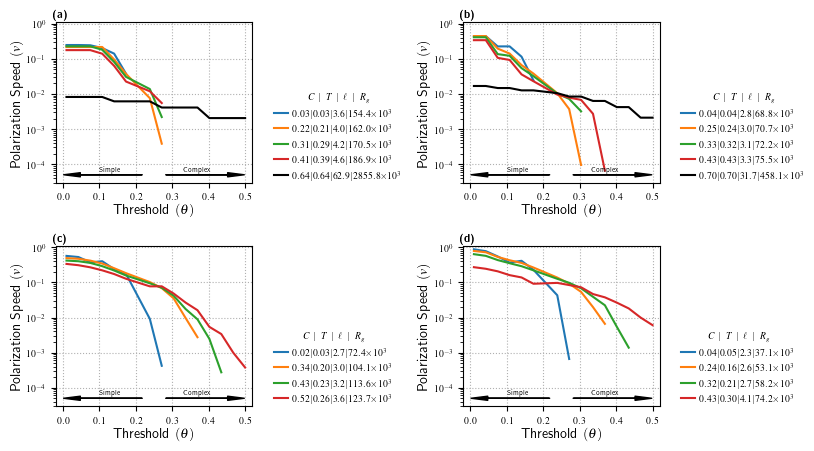

In [13]:
'''
Figure 7
LTM the K-effect (Average degree effect) for 2 networks top 5%
'''
n = 1000
k = 8
cas = 0.3

model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'ws'
network = network_class


save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65],'ke':[0,10,30,20]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')




g = {'param1':[],'param2':[],'th':[]}

fig,axs = plt.subplots(figsize=(5.5*1.5,2.31*2),ncols=2,nrows=2,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]

### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
    # if len(l_label) > 3:
    #     l_label = l_label[:3]
    #     flag_l_label=1
    # # print(len(l_label))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,0].set_ylim([3*10**-5,1.12])
axs[0,0].set_xlim([-0.02,0.52])
axs[0,0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,0].tick_params(axis='x',labelsize=7)
axs[0,0].tick_params(axis='y',labelsize=7)
## Legend and title
legend0 = axs[0,0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend0.get_title().set_position((1.5,0))
legend0.get_title().set_fontsize('7')

axs[0,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')






n = 1000
k = 16
cas = 0.3


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0,1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label, c='black')
    elif idx < 12:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff



axs[0,1].set_yscale('log')
axs[0,1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,1].set_ylim([3*10**-5,1.12])
axs[0,1].set_xlim([-0.02,0.52])
axs[0,1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,1].tick_params(axis='x',labelsize=7)
axs[0,1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[0,1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[0,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


# for ax in axs:
#     ax.text(0.055,0.9,r'{\fontfamily{phv}\selectfont  \textbf{Simple}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
#     ax.text(0.69,0.9,r'{\fontfamily{phv}\selectfont   \textbf{Complex}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
axs[0,0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0,0].transAxes,fontsize=8)
axs[0,1].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[0,1].transAxes,fontsize=8)

axs[0,0].grid(True, which="major", ls=":")
axs[0,1].grid(True, which="major", ls=":")



'''

Second network setting

'''

n = 1000
k = 8
cas = 0.3

model_type = 'LTM'
network_class = 'mhk'
network = network_class



nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')




g = {'param1':[],'param2':[],'th':[]}

flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1,0].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))

    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1,0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1,0].set_ylim([3*10**-5,1.12])
axs[1,0].set_xlim([-0.02,0.52])
axs[1,0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1,0].tick_params(axis='x',labelsize=7)
axs[1,0].tick_params(axis='y',labelsize=7)
## Legend and title
legend0 = axs[1,0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend0.get_title().set_position((1.5,0))
legend0.get_title().set_fontsize('7')

axs[1,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[1,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')






n = 1000
k = 16
cas = 0.3


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1,1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label, c='black')
    elif idx < 12:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff



axs[1,1].set_yscale('log')
axs[1,1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1,1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1,1].set_ylim([3*10**-5,1.12])
axs[1,1].set_xlim([-0.02,0.52])
axs[1,1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1,1].tick_params(axis='x',labelsize=7)
axs[1,1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[1,1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[1,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


axs[1,0].text(-0.02,1.03,r'\textbf{(c)}',transform=axs[1,0].transAxes,fontsize=8)
axs[1,1].text(-0.02,1.03,r'\textbf{(d)}',transform=axs[1,1].transAxes,fontsize=8)

axs[1,0].grid(True, which="major", ls=":")
axs[1,1].grid(True, which="major", ls=":")


if save:
    fig_path = f'figs'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'/Figure_7.pdf')
    print('fig saved')
else:
    fig.show()

In [11]:
'''
Figure 8
LFC Plotting
top_2Ks
Side-by-Side for one 2Ks and one network
'''



model = 'LFC'
nets = ['ws', 'mhk'] #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
t_b = 'top' #['top','bot','all']
Ks  = [8,16]
centrality = 'degree'

# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'

fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7*1.8),ncols=2,nrows=2,sharex=False,sharey=False)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.3)
for selc, net in enumerate(nets):
    for selector,in_k in enumerate(Ks):
        ix=pd.IndexSlice
        intended_k = in_k
        networks = [net]
        network = net
        nodes = 240

        def linepointstyle(order, color, marker):
            """Return style parameters for a
            solid line of a given color and
            order with points denoted by a
            given marker.
            """
            return {'zorder': order, 'lw': 1.5, 'c': color, 'ls': '-', 'marker': marker,
                    'markeredgecolor': color, 'markersize': 5, 'clip_on': False}

        def pointstyle(order, color, marker):
            """Return style parameters for a
            points of a given color and order,
            denoted by a given marker.
            """
            return {'zorder': order, 'color': color, 'marker': marker,
                    's': 30, 'clip_on': False}

        colors = ['r','b','g','y']
        markers = 's ^ o v'.split()
        lp_main = [linepointstyle(10 - i, colors[i], markers[i]) for i in range(4)]


        net_styles = [{'node_color': to_hex(p['c']),
                       'node_shape': '.',
                       'node_shape': p['marker'],
                       'width': 0.005, #p['lw'],
                       'edge_color': to_hex(p['c']),
                       'node_size': 0.01} for p in lp_main]


        ps_main = [pointstyle(10 - i, colors[i], markers[i]) for i in range(4)]

        print('Loading data ..,')


        d = {'ID':[],'freq':[],'p':[]}
        network_gains = pd.DataFrame(data=d)
        network_gains.set_index(['ID','freq','p'],inplace=True)

        e = {'ID':[],'p':[]}
        network_props = pd.DataFrame(data=e)
        network_props.set_index(['ID','p'],inplace=True)

        insert = True
        landscape = True

        # main_props = ['CC','SP','Rg']
        main_props = ['CC','T','SP','Rg']
        aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
        props = main_props + aux_props
        # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
        prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}



        print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
        k = in_k
        new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
        new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])

        new_props['p'] = new_props.index.get_level_values(1)

        new_props['k'] = k
        new_props['rawCC'] = new_props.CC
        new_props['rawSP'] = new_props.SP
        new_props['rawRg'] = new_props.Rg
        new_props['rawT'] = new_props['T']
        new_props.CC = new_props.CC/new_props.CC.max()
        new_props['T'] = new_props['T']/new_props['T'].max()
        new_props.Rg = new_props.Rg/new_props.Rg.min()
        new_props.SP = new_props.SP/new_props.SP.min()

        for f in new_network_gains.index.unique():
            new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())


        if 'k' in new_network_gains.columns:
            new_network_gains.loc[network_gains.isnull().k,'k']=k
        else:
            new_network_gains['k'] = k

            network_props = pd.concat([network_props, new_props.loc[:,props]])
            # network_props = network_props.append(new_props.loc[:,props])

            new_network_gains = new_network_gains.reset_index()
            new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

            new_network_gains.set_index(['ID','freq'],inplace=True)

            # network_gains = network_gains.append(new_network_gains)
            network_gains = pd.concat([network_gains, new_network_gains])

        network_props.fillna(value=0,inplace = True)
        network_gains.fillna(value=0,inplace = True)


        if network == 'mhk':
            specialp = [20,85,97,99] #k = 16 [0.14,0.27,0.50,0.175]

        elif network == 'ws':
            specialp = [51,30,12,7]
        elif network == 'ke':
            specialp = [20,90,97,99]

        print(f'Plotting ..,')

        my_new_colors = ['darkslateblue','darkcyan','coral','blue']

        cf = -3
        sf = 0



        ## Getting correct plot setup
        # bigax = axs[selc, selector]

        ## Formating collective frequency response
        axs[selc, selector].set_xscale('log')
        axs[selc, selector].set_yscale('log')
        axs[selc, selector].set_xlabel(r'Frequency $(\omega)$',labelpad=2)
        axs[selc, selector].set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)

        specialk = intended_k
        # networks/{model}/{nodes}/{network}/{k}_props.csv
        directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
        sorted_filenames = get_sorted_filenames(directory_path)

        network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
        prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
        gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
        for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
            flag_l_label = 0

            C_label = str(prop_special.loc[p].rawCC.round(2))
            if len(C_label) < 4:
                C_label =  C_label + '0'
            l_label = str(prop_special.loc[p].rawSP.round(2))

            if len(l_label) < 5:
                flag_l_label=1

            r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
            # if len(r_label) > 3:
            #     r_label = r_label[:2]
            r_label = r_label + r'\! \times \! 10^{3}'


            if flag_l_label:
                label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
            # else:
            #     label_string =fr'${C_label}  |  {prop_special.loc[p].rawSP:.2f} \, |  {r_label}  \, |  {prop_special.loc[p][3]:.2f}$'

            pol_fig_legend_label = label_string 
            # print(network,p,intended_k)


            # G = gt.load_graph(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
            # print(directory_path+f'{sorted_filenames[specialp[th]]}.gt')
            # eig_lap = np.linalg.eigvalsh(gt.spectral.laplacian(G, norm=True).todense())

            axs[selc, selector].plot(gain_special.loc[p].H2.iloc[sf:cf],label=label_string)



        leg1 = axs[selc, selector].legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\;\,\,\;\, \ell   \,\;\,\;\:\,\;\,  | \;\,\,\;\, R_{g} $', loc=[0.025,0.1],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)

        leg1.get_title().set_position((3.55, 0))
        leg1.get_title().set_fontsize('7')
        leg1.get_frame().set_facecolor('white')
        leg1.get_frame().set_alpha(1.0)
        leg1.get_frame().set_edgecolor('white')

        ps_main[3]['s'] = 0.5
        ps_main[3]['zorder'] = 20

        ## Set axis limits
        axs[selc, selector].set_xlim([0.0001,2])
        axs[selc, selector].set_ylim([0.017,520])

        ## Title



        ## Indentifying letters
        axs[0,0].text(-0.02,1.03,r'$\bf{(a)}$',transform=axs[0,0].transAxes,fontsize=8)
        axs[0,1].text(-0.02,1.03,r'$\bf{(b)}$',transform=axs[0,1].transAxes,fontsize=8)
        axs[1,0].text(-0.02,1.03,r'$\bf{(c)}$',transform=axs[1,0].transAxes,fontsize=8)
        axs[1,1].text(-0.02,1.03,r'$\bf{(d)}$',transform=axs[1,1].transAxes,fontsize=8)
        ## text boxes
        box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)

        axs[selc, selector].grid(True, which="major", ls=":")

        axs[selc, selector].tick_params(axis='x',labelsize=7)
        axs[selc, selector].tick_params(axis='y',labelsize=7)

        ## Title


        ## text boxes
        box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)


        axs[selc, selector].annotate(
            '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        axs[selc, selector].annotate(
            '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
            arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
        )

        # Add text on the right saying "complex"
        axs[selc, selector].text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
        axs[selc, selector].text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')


plt.show()

fig_path = f"figs"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(f'{fig_path}/Figure_8.pdf')

Loading data ..,
8/240/top/5/ws
Plotting ..,
Loading data ..,
16/240/top/5/ws
Plotting ..,
Loading data ..,
8/240/top/5/mhk
Plotting ..,
Loading data ..,
16/240/top/5/mhk
Plotting ..,


In [12]:
'''
LTM all cascade plotings for SM
Figures S1 S2 S3 S4
spectrum y-axis limt MKH(3.1)
'''

network_type = 'mhk'
model = 'LTM'
network = network_type
n = 1000
k = 16
# selector = ['top'] # centrality selector
# percentage = [int(n/20)] # number of nodes to choose
selector = ['top','top','bot','bot'] # centrality selector
percentage = [int(n/10),int(n/20),-int(n/20),-int(n/10)] # number of nodes to choose


# centrality = 'top'
# percen =  int(n/10)
save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch
sub_plot_tag = 'abcdefghij'
## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

counter = 1
for centrality,percen in zip(selector,percentage):
    nets_prop_file =  f'networks/{model}/{n}/{network_type}/{k}_props.csv'
    polarization_file = f'networks/{model}/{n}/{network_type}/{k}_{centrality}{percen}.csv'


    network_props=pd.read_csv(nets_prop_file,sep='\t')
    network_props.set_index(['ID','network','p'],inplace=True)

    polarization=pd.read_csv(polarization_file,sep='\t')
    polarization.set_index(['ID','network','p','th','seed'],inplace=True)

    polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
    mpol = polarization.groupby(['p','th','network']).agg(custom_mean)

    g = {'param1':[],'param2':[],'th':[]}

    fig,axs = plt.subplots(figsize=(5.5*1.5*2,2.31*6.5),ncols=3,nrows=4,sharex=False,sharey=False,tight_layout=True)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)



    flag_l_label=0
    probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
    # for cas in cascades[:]: # different cascades 
    ### Plotting loop

    corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
    for i,cas in enumerate(cascades[:]):
        # print(f'Cascade size {cas,i}')
        ax = axs[i//3,i%3]
        ax.get_xaxis().get_major_formatter().set_scientific(False)

        for idx,p in enumerate(probabilities[::-1]):
            C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
            if len(C_label) < 4:
                C_label =  C_label + '0'

            T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
            if len(T_label) < 4:
                T_label =  T_label + '0'

            l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
            if len(l_label) > 4:
                l_label = l_label[:3]
                flag_l_label=1
            # print(len(l_label))

            r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
            # if len(r_label) > 3:
            #     r_label = r_label[:2]
            r_label = r_label + r'\! \times \! 10^{3}'

            label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)



            pol_fig_legend_label = label_string
            #Make lines distingushable
            G = gt.load_graph(f'networks/{model}/{n}/{network_type}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
            eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())

            ax.text(-0.02,1.03,fr'\textbf{{({sub_plot_tag[i]})}} Cascade size: {int(float(cas)*100)}\% activated nodes',transform=ax.transAxes,fontsize=15)
            # ax.text(-0.02, 1.03, f'({sub_plot_tag[i]}) Cascade size: {int(float(cas)*100)}\% activated nodes', 
                    # transform=ax.transAxes, fontsize=15, fontweight='bold')
            ax.set_yscale('log')
            ax.set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5,fontsize = 14)
            ax.set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm',fontsize = 14)
            ax.set_ylim([3*10**-5,1.12])
            ax.set_xlim([-0.02,0.52])
            ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
            ax.tick_params(axis='x',labelsize=13)
            ax.tick_params(axis='y',labelsize=13)

            ax.grid(True, which="major", ls=":")

            ax.annotate(
                '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
                arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
            )
            
            ax.annotate(
                '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
                arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
            )
            
            # Add text on the right saying "complex"
            ax.text(0.1, 7*10**-5, 'Simple', fontsize=14, verticalalignment='center')
            ax.text(0.33, 7*10**-5, 'Complex', fontsize=14, verticalalignment='center')

            if idx < 4:
                ax.plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,linewidth=3)

            elif idx < 8:
                ax.plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black', linewidth=3)

            if i==0:
                if idx < 4:
                    axs[3][1].hist(eig_lap, bins=100, density=True, alpha=0.6,label=pol_fig_legend_label)

                elif idx < 8:
                    axs[3][1].hist(eig_lap, bins=100, density=True, alpha=0.6,label=pol_fig_legend_label,color='black')

                axs[3][1].text(-0.02,1.03,fr'\textbf{{({sub_plot_tag[9]})}}',transform=axs[3][1].transAxes,fontsize=15)
                # axs[3][1].text(-0.02, 1.03, f'({sub_plot_tag[9]})',transform=axs[3][1].transAxes, fontsize=15, fontweight='bold')
                axs[3][1].set_ylabel(r'Density',labelpad=2.5,fontsize = 14)
                axs[3][1].set_xlabel(r'Normalized Laplacian eigenvalues',labelpad=2,math_fontfamily='cm',fontsize = 14)
                axs[3][1].set_ylim([0,3.1])  # WS [0,8], MHK [0,4]
                axs[3][1].set_xlim([-0.02,2.05])
                axs[3][1].tick_params(axis='x',labelsize=13)
                axs[3][1].tick_params(axis='y',labelsize=13)

    ## Legend and title
    axs[3][0].remove()
    axs[3][2].axis('off')

    # Turn axs[3][2] into an empty canvas
    axs[3][2].axis('off')
    
    # Get handles and labels from axs[3][1]
    handles, labels = axs[3][1].get_legend_handles_labels()
    
    # Create the legend in axs[3][2]
    legend0 = axs[3][2].legend(
        handles, labels,
        title=r'$C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g}$',
        title_fontsize=16,
        fontsize=14,
        loc=[-0.12, 0],
        frameon=False
    )
    
    
    legend0.get_title().set_position((1.5,0))
    legend0.get_title().set_fontsize('14')


# Then, set the title to have normal weight (if you don't want bold)
    legend0.get_title().set_fontweight('normal')

    # plt.show()
    # fig.savefig(f'figures/fig1/{network}/fig1_{cas}.pdf')
    if save:
        fig_path = f'figs/'
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(fig_path + f'Figure_S{counter}.pdf')
        counter +=1
        print(f'fig {network_type}_{n}_{k}_allcas_{model}_{centrality}{int(percen/n*100)}.pdf saved')
        plt.close()
    else:
        fig.show()


fig mhk_1000_16_allcas_LTM_top10.pdf saved
fig mhk_1000_16_allcas_LTM_top5.pdf saved
fig mhk_1000_16_allcas_LTM_bot-5.pdf saved
fig mhk_1000_16_allcas_LTM_bot-10.pdf saved


In [13]:
'''
LTM all cascade plotings for SM
Figures S5 S6 S7 S8
Spectrum y-axis limit for WS(4)
'''

network_type = 'ws'
model = 'LTM'
network = network_type
n = 1000
k = 16
# selector = ['top'] # centrality selector
# percentage = [int(n/20)] # number of nodes to choose
selector = ['top','top','bot','bot'] # centrality selector
percentage = [int(n/10),int(n/20),-int(n/20),-int(n/10)] # number of nodes to choose


# centrality = 'top'
# percen =  int(n/10)
save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch
sub_plot_tag = 'abcdefghij'
## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

counter = 5
for centrality,percen in zip(selector,percentage):
    nets_prop_file =  f'networks/{model}/{n}/{network_type}/{k}_props.csv'
    polarization_file = f'networks/{model}/{n}/{network_type}/{k}_{centrality}{percen}.csv'


    network_props=pd.read_csv(nets_prop_file,sep='\t')
    network_props.set_index(['ID','network','p'],inplace=True)

    polarization=pd.read_csv(polarization_file,sep='\t')
    polarization.set_index(['ID','network','p','th','seed'],inplace=True)

    polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
    mpol = polarization.groupby(['p','th','network']).agg(custom_mean)

    g = {'param1':[],'param2':[],'th':[]}

    fig,axs = plt.subplots(figsize=(5.5*1.5*2,2.31*6.5),ncols=3,nrows=4,sharex=False,sharey=False,tight_layout=True)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)



    flag_l_label=0
    probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
    # for cas in cascades[:]: # different cascades 
    ### Plotting loop

    corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
    for i,cas in enumerate(cascades[:]):
        # print(f'Cascade size {cas,i}')
        ax = axs[i//3,i%3]
        ax.get_xaxis().get_major_formatter().set_scientific(False)

        for idx,p in enumerate(probabilities[::-1]):
            C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
            if len(C_label) < 4:
                C_label =  C_label + '0'

            T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
            if len(T_label) < 4:
                T_label =  T_label + '0'

            l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
            if len(l_label) > 4:
                l_label = l_label[:3]
                flag_l_label=1
            # print(len(l_label))

            r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
            # if len(r_label) > 3:
            #     r_label = r_label[:2]
            r_label = r_label + r'\! \times \! 10^{3}'

            label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)



            pol_fig_legend_label = label_string
            #Make lines distingushable
            G = gt.load_graph(f'networks/{model}/{n}/{network_type}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
            eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())

            ax.text(-0.02,1.03,fr'\textbf{{({sub_plot_tag[i]})}} Cascade size: {int(float(cas)*100)}\% activated nodes',transform=ax.transAxes,fontsize=15)
            # ax.text(-0.02, 1.03, f'({sub_plot_tag[i]}) Cascade size: {int(float(cas)*100)}\% activated nodes', 
                    # transform=ax.transAxes, fontsize=15, fontweight='bold')
            ax.set_yscale('log')
            ax.set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5,fontsize = 14)
            ax.set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm',fontsize = 14)
            ax.set_ylim([3*10**-5,1.12])
            ax.set_xlim([-0.02,0.52])
            ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
            ax.tick_params(axis='x',labelsize=13)
            ax.tick_params(axis='y',labelsize=13)

            ax.grid(True, which="major", ls=":")

            ax.annotate(
                '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
                arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
            )
            
            ax.annotate(
                '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
                arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
            )
            
            # Add text on the right saying "complex"
            ax.text(0.1, 7*10**-5, 'Simple', fontsize=14, verticalalignment='center')
            ax.text(0.33, 7*10**-5, 'Complex', fontsize=14, verticalalignment='center')

            if idx < 4:
                ax.plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,linewidth=3)

            elif idx < 8:
                ax.plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black', linewidth=3)

            if i==0:
                if idx < 4:
                    axs[3][1].hist(eig_lap, bins=100, density=True, alpha=0.6,label=pol_fig_legend_label)

                elif idx < 8:
                    axs[3][1].hist(eig_lap, bins=100, density=True, alpha=0.6,label=pol_fig_legend_label,color='black')

                axs[3][1].text(-0.02,1.03,fr'\textbf{{({sub_plot_tag[9]})}}',transform=axs[3][1].transAxes,fontsize=15)
                # axs[3][1].text(-0.02, 1.03, f'({sub_plot_tag[9]})',transform=axs[3][1].transAxes, fontsize=15, fontweight='bold')
                axs[3][1].set_ylabel(r'Density',labelpad=2.5,fontsize = 14)
                axs[3][1].set_xlabel(r'Normalized Laplacian eigenvalues',labelpad=2,math_fontfamily='cm',fontsize = 14)
                axs[3][1].set_ylim([0,4])  # WS [0,8], MHK [0,4]
                axs[3][1].set_xlim([-0.02,2.05])
                axs[3][1].tick_params(axis='x',labelsize=13)
                axs[3][1].tick_params(axis='y',labelsize=13)

    ## Legend and title
    axs[3][0].remove()
    axs[3][2].axis('off')

    # Turn axs[3][2] into an empty canvas
    axs[3][2].axis('off')
    
    # Get handles and labels from axs[3][1]
    handles, labels = axs[3][1].get_legend_handles_labels()
    
    # Create the legend in axs[3][2]
    legend0 = axs[3][2].legend(
        handles, labels,
        title=r'$C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g}$',
        title_fontsize=16,
        fontsize=14,
        loc=[-0.12, 0],
        frameon=False
    )
    
    
    legend0.get_title().set_position((1.5,0))
    legend0.get_title().set_fontsize('14')


# Then, set the title to have normal weight (if you don't want bold)
    legend0.get_title().set_fontweight('normal')

    # plt.show()
    # fig.savefig(f'figures/fig1/{network}/fig1_{cas}.pdf')
    if save:
        fig_path = f'figs'
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        # fig.savefig(fig_path + f'/{network_type}_{n}_{k}_allcas_{model}_{centrality}{int(percen/n*100)}.pdf')
        fig.savefig(fig_path + f'/Figure_S{counter}.pdf')
        print(f'fig {network_type}_{n}_{k}_allcas_{model}_{centrality}{int(percen/n*100)}.pdf saved')
        counter += 1
        plt.close()
    else:
        fig.show()


fig ws_1000_16_allcas_LTM_top10.pdf saved
fig ws_1000_16_allcas_LTM_top5.pdf saved
fig ws_1000_16_allcas_LTM_bot-5.pdf saved
fig ws_1000_16_allcas_LTM_bot-10.pdf saved


plotting
Cascade size 0.3
Cascade size 0.3
fig saved


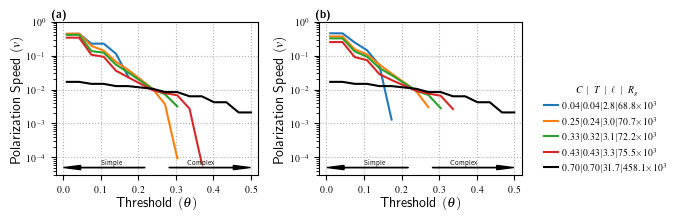

In [10]:
'''
Figure S9
LTM mhk top bottom 5%
LTM plotings 1*2 to show hub and non-hub
'''

n = 1000
k = 16
cas = 0.3

model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'ws'
network = network_class


save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65],'ke':[0,10,30,20]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file = f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')


g = {'param1':[],'param2':[],'th':[]}
# network_corr = pd.DataFrame(data=g)
# network_corr.set_index(['param1','param2','th'],inplace=True)
methods = ['pearson','spearman']

fig,axs = plt.subplots(figsize=(5.5*1.25,2.31),ncols=2,nrows=1,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))

    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[0].set_yscale('log')
axs[0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0].set_ylim([3*10**-5,1])
axs[0].set_xlim([-0.02,0.52])
axs[0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0].tick_params(axis='x',labelsize=7)
axs[0].tick_params(axis='y',labelsize=7)
## Legend and title
# legend0 = axs[0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
# legend0.get_title().set_position((1.5,0))
# legend0.get_title().set_fontsize('7')

axs[0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


network_root = f'bot{-int(n/20)}'


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c = 'black')
    elif idx < 12:
        axs[1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff

axs[1].set_yscale('log')
axs[1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1].set_ylim([3*10**-5,1])
axs[1].set_xlim([-0.02,0.52])
axs[1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1].tick_params(axis='x',labelsize=7)
axs[1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


axs[0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0].transAxes,fontsize=8)
axs[1].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[1].transAxes,fontsize=8)

axs[0].grid(True, which="major", ls=":")
axs[1].grid(True, which="major", ls=":")


if save:
    fig_path = f'figs/'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'Figure_S9.pdf')
    print('fig saved')
else:
    fig.show()

In [15]:
'''
Figure S10
LTM the K-effect (Average degree effect) for 2 networks bot 5%
'''
n = 1000
k = 8
cas = 0.3

model_type = 'LTM'
network_root = f'bot-{int(n/20)}'
network_class = 'ws'
network = network_class


save = True
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65],'ke':[0,10,30,20]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

## Pick which cascade sizes are consider, valid choises are 0.1,0.2,...,0.9
cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')




g = {'param1':[],'param2':[],'th':[]}

fig,axs = plt.subplots(figsize=(5.5*1.5,2.31*2),ncols=2,nrows=2,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]

### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
    # if len(l_label) > 3:
    #     l_label = l_label[:3]
    #     flag_l_label=1
    # # print(len(l_label))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,0].set_ylim([3*10**-5,1.12])
axs[0,0].set_xlim([-0.02,0.52])
axs[0,0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,0].tick_params(axis='x',labelsize=7)
axs[0,0].tick_params(axis='y',labelsize=7)
## Legend and title
legend0 = axs[0,0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend0.get_title().set_position((1.5,0))
legend0.get_title().set_fontsize('7')

axs[0,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')






n = 1000
k = 16
cas = 0.3


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[0,1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label, c='black')
    elif idx < 12:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff



axs[0,1].set_yscale('log')
axs[0,1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,1].set_ylim([3*10**-5,1.12])
axs[0,1].set_xlim([-0.02,0.52])
axs[0,1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,1].tick_params(axis='x',labelsize=7)
axs[0,1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[0,1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[0,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)


# Add text on the right saying "complex"
axs[0,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


# for ax in axs:
#     ax.text(0.055,0.9,r'{\fontfamily{phv}\selectfont  \textbf{Simple}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
#     ax.text(0.69,0.9,r'{\fontfamily{phv}\selectfont   \textbf{Complex}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
axs[0,0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0,0].transAxes,fontsize=8)
axs[0,1].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[0,1].transAxes,fontsize=8)

axs[0,0].grid(True, which="major", ls=":")
axs[0,1].grid(True, which="major", ls=":")



'''

Second network setting

'''

n = 1000
k = 8
cas = 0.3

model_type = 'LTM'
network_class = 'mhk'
network = network_class



nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)


print('plotting')




g = {'param1':[],'param2':[],'th':[]}

flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1,0].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))

    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label,c='black')
    elif idx < 12:
        axs[1,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1,0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1,0].set_ylim([3*10**-5,1.12])
axs[1,0].set_xlim([-0.02,0.52])
axs[1,0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1,0].tick_params(axis='x',labelsize=7)
axs[1,0].tick_params(axis='y',labelsize=7)
## Legend and title
legend0 = axs[1,0].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend0.get_title().set_position((1.5,0))
legend0.get_title().set_fontsize('7')

axs[1,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[1,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')






n = 1000
k = 16
cas = 0.3


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)






flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
# for cas in cascades[:]: # different cascades 
axs[1,1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
print(f'Cascade size {cas}')
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    G = gt.load_graph(f'networks/{model_type}/{n}/{network_class}/{k}/'+f'{round(network_props.loc[ix[:,network,p],:].index[0][0])}.gt')
    eig_lap = np.linalg.eigvalsh(gt.laplacian(G, norm=True).todense())
    #Make lines distingushable
    if idx < 4:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label, c='black')
    elif idx < 12:
        axs[1,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff



axs[1,1].set_yscale('log')
axs[1,1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[1,1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[1,1].set_ylim([3*10**-5,1.12])
axs[1,1].set_xlim([-0.02,0.52])
axs[1,1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[1,1].tick_params(axis='x',labelsize=7)
axs[1,1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[1,1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[1,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[1,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[1,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')

# for ax in axs:
#     ax.text(0.055,0.9,r'{\fontfamily{phv}\selectfont  \textbf{Simple}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
#     ax.text(0.69,0.9,r'{\fontfamily{phv}\selectfont   \textbf{Complex}}',transform=ax.transAxes,bbox=box_props,fontsize=7,fontdict={'family':'sans-serif'})
axs[1,0].text(-0.02,1.03,r'\textbf{(c)}',transform=axs[1,0].transAxes,fontsize=8)
axs[1,1].text(-0.02,1.03,r'\textbf{(d)}',transform=axs[1,1].transAxes,fontsize=8)

axs[1,0].grid(True, which="major", ls=":")
axs[1,1].grid(True, which="major", ls=":")


if save:
    fig_path = f'figs'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'/Figure_S10.pdf')
    print('fig saved')
else:
    fig.show()

plotting
Cascade size 0.3
Cascade size 0.3
plotting
Cascade size 0.3
Cascade size 0.3
fig saved


In [16]:
'''
Figure S11
'''


model = 'LFC'
net = 'ws' #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
Ks  = [16]
centrality = 'degree'
# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'
for in_k in Ks:
    ix=pd.IndexSlice
    intended_k = in_k
    networks = [net]
    network = net
    nodes = 240
    
    print('Loading data ..,')
    if network == 'mhk':
        specialp = [20,85,97,99]
    elif network == 'ws':
        specialp = [51,30,12,7]
    elif network == 'ke':
        specialp = [20,90,97,99]

    fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7*2),ncols=2,nrows=2,sharex=False,sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.3)
    ## Getting correct plot setup
    axs = axs.flatten()
    
    ## Formating collective frequency response
   
    
    for thi ,i in enumerate(specialp):
        # gs = axs[thi].get_gridspec()
        bigax = axs[thi]
        bigax.set_xscale('log')
        bigax.set_yscale('log')
        bigax.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
        bigax.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)
        for thl, t_b in enumerate (['top','bot']):
            d = {'ID':[],'freq':[],'p':[]}
            network_gains = pd.DataFrame(data=d)
            network_gains.set_index(['ID','freq','p'],inplace=True)
        
            e = {'ID':[],'p':[]}
            network_props = pd.DataFrame(data=e)
            network_props.set_index(['ID','p'],inplace=True)
        
            insert = True
            landscape = True
        
            # main_props = ['CC','SP','Rg']
            main_props = ['CC','T','SP','Rg']
            aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
            props = main_props + aux_props
            # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
            prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}
            print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
            
            k = in_k
            new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
            new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])
        
            new_props['p'] = new_props.index.get_level_values(1)
        
            new_props['k'] = k
            new_props['rawCC'] = new_props.CC
            new_props['rawSP'] = new_props.SP
            new_props['rawRg'] = new_props.Rg
            new_props['rawT'] = new_props['T']
            new_props.CC = new_props.CC/new_props.CC.max()
            new_props['T'] = new_props['T']/new_props['T'].max()
            new_props.Rg = new_props.Rg/new_props.Rg.min()
            new_props.SP = new_props.SP/new_props.SP.min()
        
            for f in new_network_gains.index.unique():
                new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())
        
        
            if 'k' in new_network_gains.columns:
                new_network_gains.loc[network_gains.isnull().k,'k']=k
            else:
                new_network_gains['k'] = k
        
                network_props = pd.concat([network_props, new_props.loc[:,props]])
                # network_props = network_props.append(new_props.loc[:,props])
        
                new_network_gains = new_network_gains.reset_index()
                new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))
        
                new_network_gains.set_index(['ID','freq'],inplace=True)
        
                # network_gains = network_gains.append(new_network_gains)
                network_gains = pd.concat([network_gains, new_network_gains])
        
            network_props.fillna(value=0,inplace = True)
            network_gains.fillna(value=0,inplace = True)
        
            print(f'Plotting ..,')
        
            my_new_colors = ['tab:blue','tab:orange','tab:green','tab:red']
        
            lin_style = ['solid',':']
           
            
            specialk = intended_k
            # networks/{model}/{nodes}/{network}/{k}_props.csv
            directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
            sorted_filenames = get_sorted_filenames(directory_path)
        
            network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
            prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
            gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
            for th,p in enumerate(gain_special.index.get_level_values(0).unique()[[i]]):
                flag_l_label = 0
        
                C_label = str(prop_special.loc[p].rawCC.round(2))
                if len(C_label) < 4:
                    C_label =  C_label + '0'
                l_label = str(prop_special.loc[p].rawSP.round(2))
        
                if len(l_label) < 5:
                    flag_l_label=1
        
                r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
                # if len(r_label) > 3:
                #     r_label = r_label[:2]
                r_label = r_label + r'\! \times \! 10^{3}'
        
        
                if flag_l_label:
                    label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
                # else:
                #     label_string =fr'${C_label}  |  {prop_special.loc[p].rawSP:.2f} \, |  {r_label}  \, |  {prop_special.loc[p][3]:.2f}$'
        
                pol_fig_legend_label = label_string 
                # print(network,p,intended_k)
        
                bigax.plot(gain_special.loc[p].H2 ,label= label_string, color = my_new_colors[thi], linestyle = lin_style[thl] )
        
                leg1 = bigax.legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\;\,\,\;\, \ell   \,\;\,\;\:\,\;\,  | \;\,\,\;\, R_{g}    \,\;\,\;\:\,\;\,$', loc=[0.025,0.07],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)
                
                leg1.get_title().set_position((3.55, 0))
                leg1.get_title().set_fontsize('7')
                leg1.get_frame().set_facecolor('white')
                leg1.get_frame().set_alpha(1.0)
                leg1.get_frame().set_edgecolor('white')
                
                ## Set axis limits
                bigax.set_xlim([0.0001,2])
                bigax.set_ylim([0.017,520])
                ## Title
            
            
                sub_ind = 'abcd'
                ## Indentifying letters
                bigax.text(-0.02,1.03,rf'$\bf({sub_ind[thi]})$',transform=bigax.transAxes,fontsize=8)
            
                ## text boxes
                box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)
            
                bigax.grid(True, which="major", ls=":")
            
                bigax.tick_params(axis='x',labelsize=7)
                bigax.tick_params(axis='y',labelsize=7)
            
                ## Title
             
            
                ## text boxes
                box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)
            
            
                bigax.annotate(
                    '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
                    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
                )
            
                bigax.annotate(
                    '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
                    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
                )
                bigax.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
                bigax.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')
    plt.show()
    
    fig_path = f"figs"
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(f'{fig_path}/Figure_S11.pdf')
    print(f'{fig_path}/{networks[0]}_{intended_k}_top_bot_{perc}_LFC_{centrality}_indv.pdf')

Loading data ..,
16/240/top/5/ws
Plotting ..,
16/240/bot/5/ws
Plotting ..,
16/240/top/5/ws
Plotting ..,
16/240/bot/5/ws
Plotting ..,
16/240/top/5/ws
Plotting ..,
16/240/bot/5/ws
Plotting ..,
16/240/top/5/ws
Plotting ..,
16/240/bot/5/ws
Plotting ..,
figs/ws_16_top_bot_5_LFC_degree_indv.pdf


In [17]:
'''
Figure S12

'''


model = 'LFC'
net = 'mhk' #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
Ks  = [16]
centrality = 'degree'
# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'
for in_k in Ks:
    ix=pd.IndexSlice
    intended_k = in_k
    networks = [net]
    network = net
    nodes = 240
    
    print('Loading data ..,')
    if network == 'mhk':
        specialp = [20,85,97,99]
    elif network == 'ws':
        specialp = [51,30,12,7]
    elif network == 'ke':
        specialp = [20,90,97,99]

    fig,axs = plt.subplots(figsize=(5.5*1.2,2.1*1.7*2),ncols=2,nrows=2,sharex=False,sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=0.3)
    ## Getting correct plot setup
    axs = axs.flatten()
    
    ## Formating collective frequency response
   
    
    for thi ,i in enumerate(specialp):
        # gs = axs[thi].get_gridspec()
        bigax = axs[thi]
        bigax.set_xscale('log')
        bigax.set_yscale('log')
        bigax.set_xlabel(r'Frequency $(\omega)$',labelpad=2)
        bigax.set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)
        for thl, t_b in enumerate (['top','bot']):
            d = {'ID':[],'freq':[],'p':[]}
            network_gains = pd.DataFrame(data=d)
            network_gains.set_index(['ID','freq','p'],inplace=True)
        
            e = {'ID':[],'p':[]}
            network_props = pd.DataFrame(data=e)
            network_props.set_index(['ID','p'],inplace=True)
        
            insert = True
            landscape = True
        
            # main_props = ['CC','SP','Rg']
            main_props = ['CC','T','SP','Rg']
            aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
            props = main_props + aux_props
            # prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$'}
            prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}
            print(f'{in_k}/{nodes}/{t_b}/{perc}/{networks[0]}')
            
            k = in_k
            new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
            new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])
        
            new_props['p'] = new_props.index.get_level_values(1)
        
            new_props['k'] = k
            new_props['rawCC'] = new_props.CC
            new_props['rawSP'] = new_props.SP
            new_props['rawRg'] = new_props.Rg
            new_props['rawT'] = new_props['T']
            new_props.CC = new_props.CC/new_props.CC.max()
            new_props['T'] = new_props['T']/new_props['T'].max()
            new_props.Rg = new_props.Rg/new_props.Rg.min()
            new_props.SP = new_props.SP/new_props.SP.min()
        
            for f in new_network_gains.index.unique():
                new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())
        
        
            if 'k' in new_network_gains.columns:
                new_network_gains.loc[network_gains.isnull().k,'k']=k
            else:
                new_network_gains['k'] = k
        
                network_props = pd.concat([network_props, new_props.loc[:,props]])
                # network_props = network_props.append(new_props.loc[:,props])
        
                new_network_gains = new_network_gains.reset_index()
                new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))
        
                new_network_gains.set_index(['ID','freq'],inplace=True)
        
                # network_gains = network_gains.append(new_network_gains)
                network_gains = pd.concat([network_gains, new_network_gains])
        
            network_props.fillna(value=0,inplace = True)
            network_gains.fillna(value=0,inplace = True)
        
            print(f'Plotting ..,')
        
            my_new_colors = ['tab:blue','tab:orange','tab:green','tab:red']
        
            lin_style = ['solid',':']
           
            
            specialk = intended_k
            # networks/{model}/{nodes}/{network}/{k}_props.csv
            directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'
            sorted_filenames = get_sorted_filenames(directory_path)
        
            network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
            prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
            gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
            for th,p in enumerate(gain_special.index.get_level_values(0).unique()[[i]]):
                flag_l_label = 0
        
                C_label = str(prop_special.loc[p].rawCC.round(2))
                if len(C_label) < 4:
                    C_label =  C_label + '0'
                l_label = str(prop_special.loc[p].rawSP.round(2))
        
                if len(l_label) < 5:
                    flag_l_label=1
        
                r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))
                # if len(r_label) > 3:
                #     r_label = r_label[:2]
                r_label = r_label + r'\! \times \! 10^{3}'
        
        
                if flag_l_label:
                    label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
                # else:
                #     label_string =fr'${C_label}  |  {prop_special.loc[p].rawSP:.2f} \, |  {r_label}  \, |  {prop_special.loc[p][3]:.2f}$'
        
                pol_fig_legend_label = label_string 
                # print(network,p,intended_k)
        
                bigax.plot(gain_special.loc[p].H2 ,label= label_string, color = my_new_colors[thi], linestyle = lin_style[thl] )
        
                leg1 = bigax.legend(title=r'$ \;\,\;\;\; C \;\,\;\,\;\; | \;\,\,\;\, T  \;\:\,\;\,\,\;\,  | \,\;\,\;\;\,\,\;\, \ell   \,\;\,\;\:\,\;\,  | \;\,\,\;\, R_{g}    \,\;\,\;\:\,\;\,$', loc=[0.025,0.07],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)
                
                leg1.get_title().set_position((3.55, 0))
                leg1.get_title().set_fontsize('7')
                leg1.get_frame().set_facecolor('white')
                leg1.get_frame().set_alpha(1.0)
                leg1.get_frame().set_edgecolor('white')
                
                ## Set axis limits
                bigax.set_xlim([0.0001,2])
                bigax.set_ylim([0.017,520])
                ## Title
            
            
                sub_ind = 'abcd'
                ## Indentifying letters
                bigax.text(-0.02,1.03,rf'$\bf({sub_ind[thi]})$',transform=bigax.transAxes,fontsize=8)
            
                ## text boxes
                box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)
            
                bigax.grid(True, which="major", ls=":")
            
                bigax.tick_params(axis='x',labelsize=7)
                bigax.tick_params(axis='y',labelsize=7)
            
                ## Title
             
            
                ## text boxes
                box_props = dict(alpha=1,facecolor='w',linewidth=0,zorder=100000,boxstyle='round',pad=0.4)
            
            
                bigax.annotate(
                    '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
                    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
                )
            
                bigax.annotate(
                    '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
                    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
                )
                bigax.text(8*10**-4, 3*10**-2, 'Simple', fontsize=5, verticalalignment='center')
                bigax.text(1*10**-1, 3*10**-2, 'Complex', fontsize=5, verticalalignment='center')
    plt.show()
    
    fig_path = f"figs"
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(f'{fig_path}/Figure_S12.pdf')
    print(f'{fig_path}/{networks[0]}_{intended_k}_top_bot_{perc}_LFC_{centrality}_indv.pdf')

Loading data ..,
16/240/top/5/mhk
Plotting ..,
16/240/bot/5/mhk
Plotting ..,
16/240/top/5/mhk
Plotting ..,
16/240/bot/5/mhk
Plotting ..,
16/240/top/5/mhk
Plotting ..,
16/240/bot/5/mhk
Plotting ..,
16/240/top/5/mhk
Plotting ..,
16/240/bot/5/mhk
Plotting ..,
figs/mhk_16_top_bot_5_LFC_degree_indv.pdf


In [18]:
'''
Figure S13
'''

def ke_network(n,m):

    #https://rf.mokslasplius.lt/acchieving-high-clustering-in-scale-free-networks/
    G = nx.connected_watts_strogatz_graph(m,m,0)
    cs = []
    active_nodes = list(G.nodes())
    for i in range(m,n):
        for k in active_nodes:
            G.add_edge(k,i)
        active_nodes.append(i)
        active_nodes.remove(random.choice(active_nodes))

    return G




#https://rf.mokslasplius.lt/acchieving-high-clustering-in-scale-free-networks/
m = 10
n = 1000
G = nx.connected_watts_strogatz_graph(m,m,0)
cs = []
active_nodes = list(G.nodes())
for i in range(m,n):
    for k in active_nodes:
        G.add_edge(k,i)
    active_nodes.append(i)
    active_nodes.remove(random.choice(active_nodes))
    cs.append(nx.average_clustering(G))
# plt.figure()
# nx.draw(G)
plt.figure()

G = ke_network(100,10)
fig, axs = plt.subplots(ncols=3, figsize=(14, 4), gridspec_kw={'width_ratios': [2,0.7,3]})
nx.draw_circular(G ,node_size=70, ax=axs[0])
axs[2].scatter(range(1,len(cs)+1),cs,facecolors='none', edgecolors='r')

axs[0].text(-0.02,1.03,r'\textbf{(a)}',transform=axs[0].transAxes,fontsize=16)
axs[2].text(-0.02,1.03,r'\textbf{(b)}',transform=axs[2].transAxes,fontsize=16)

axs[2].set_xlabel(r'log($N$)',labelpad=2.5)
axs[2].set_ylabel('Clustering Coefficient',labelpad=2.5)
axs[2].set_xscale('log')
fig.delaxes(axs[1])
plt.savefig('figs/Figure_S13.pdf')

Plotting LTM
Plotting LFC ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fig saved


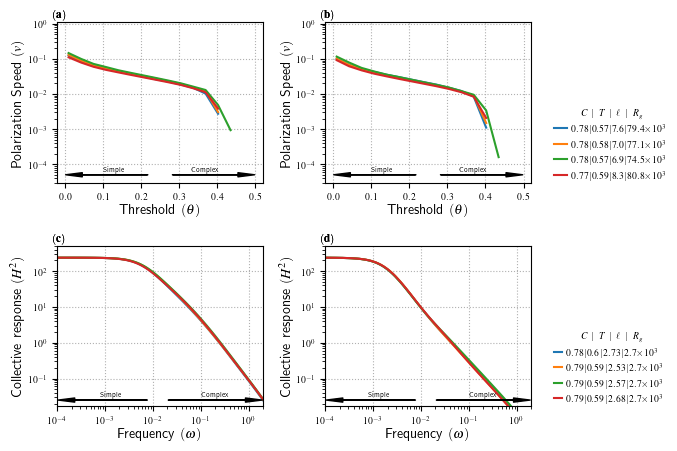

In [11]:
'''
Figure S14
LTM and LFC [16] [top and bot] HCSF
'''
print('Plotting LTM')
n = 1000
k = 16
cas = 0.3

model_type = 'LTM'
network_root = f'top{int(n/20)}'
network_class = 'ke'
network = network_class


save = True
hatching = False
pick_props = {'mhk':[99,60,10,0],'ws':[0,15,23,30,65],'ke':[0,10,30,20]}

ix = pd.IndexSlice
colors = ['darkslateblue','darkcyan','coral','blue']
#Toggle hatch

cascades = list(map(str,list(np.round(np.linspace(0.1,0.9,9),1))))

nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)



g = {'param1':[],'param2':[],'th':[]}
# network_corr = pd.DataFrame(data=g)
# network_corr.set_index(['param1','param2','th'],inplace=True)

fig,axs = plt.subplots(figsize=(5.5*1.25,2.31*2),ncols=2,nrows=2,sharex=False,sharey=False,tight_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]

### Plotting loop
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))
    # if len(l_label) > 3:
    #     l_label = l_label[:3]
    #     flag_l_label=1
    # # print(len(l_label))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    #Make lines distingushable
    if idx < 4:
        axs[0,0].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-')  # Remove label parameter
        
# Set scale stuff
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,0].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,0].set_ylim([3*10**-5,1.12])
axs[0,0].set_xlim([-0.02,0.52])
axs[0,0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,0].tick_params(axis='x',labelsize=7)
axs[0,0].tick_params(axis='y',labelsize=7)

axs[0,0].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,0].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[0,0].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,0].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')


n = 1000
k = 16
cas = 0.3

# model_type = 'LTM'
network_root = f'bot{-int(n/20)}'
# network_class = 'mhk'
# network = network_class


nets_prop_file =  f'networks/{model_type}/{n}/{network_class}/{k}_props.csv'
polarization_file = f'networks/{model_type}/{n}/{network_class}/{k}_{network_root}.csv'


network_props=pd.read_csv(nets_prop_file,sep='\t')
network_props.set_index(['ID','network','p'],inplace=True)

polarization=pd.read_csv(polarization_file,sep='\t')
polarization.set_index(['ID','network','p','th','seed'],inplace=True)

polarization = polarization[~polarization.index.get_level_values('th').isin([0.206000, 0.238667])]
mpol = polarization.groupby(['p','th','network']).agg(custom_mean)



flag_l_label=0
probabilities = np.sort(mpol.loc[ix[:,:,network],:].index.get_level_values(0).unique())[pick_props[network]]
axs[0,1].get_xaxis().get_major_formatter().set_scientific(False)
### Plotting loop
corr_fig_legend_label = [r'$C$',r'$\ell$',r'$R_g$',r'$T$']
for idx,p in enumerate(probabilities[::-1]):
    C_label = str(network_props.loc[ix[:,network,p],:]['CC'].mean().round(2))
    if len(C_label) < 4:
        C_label =  C_label + '0'

    T_label = str(network_props.loc[ix[:,network,p],:]['T'].mean().round(2))
    if len(T_label) < 4:
        T_label =  T_label + '0'

    l_label = str(network_props.loc[ix[:,network,p],:]['SP'].mean().round(1))

    r_label = str((network_props.loc[ix[:,network,p],:]['Rg'].mean()/1000).round(1))
    # if len(r_label) > 3:
    #     r_label = r_label[:2]
    r_label = r_label + r'\! \times \! 10^{3}'

    if flag_l_label:
        label_string =r'${}  |  {}  |  {}  |  {} $'.format(C_label,T_label,l_label,r_label)
    else:
        label_string =r'${}  |  {}  |  {} \, |  {} $'.format(C_label,T_label,l_label,r_label)


    pol_fig_legend_label = label_string
    if idx < 4:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label)
    elif idx < 8:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='-',label=pol_fig_legend_label, c='black')
    elif idx < 12:
        axs[0,1].plot(mpol.loc[ix[p,:,network],f'{cas}'].index.get_level_values(1),mpol.loc[ix[p,:,network],f'{cas}'],ls='--',label=pol_fig_legend_label)

# Set scale stuff

axs[0,1].set_yscale('log')
axs[0,1].set_ylabel(r'Polarization Speed $(v)$',labelpad=2.5)
axs[0,1].set_xlabel(r'Threshold $( \theta )$',labelpad=2,math_fontfamily='cm')
axs[0,1].set_ylim([3*10**-5,1.12])
axs[0,1].set_xlim([-0.02,0.52])
axs[0,1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
axs[0,1].tick_params(axis='x',labelsize=7)
axs[0,1].tick_params(axis='y',labelsize=7)

## Legend and title
legend1 = axs[0,1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', framealpha=1, facecolor='white',loc=[1.1,0],edgecolor='w',borderpad=0.2,markerscale=0.8,handlelength=1.4,handletextpad=0.4,fontsize=7)
legend1.get_title().set_position((1.5,0))
legend1.get_title().set_fontsize('7')



axs[0,1].annotate(
    '', xy=(0.0, 5*10**-5), xytext=(0.22, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

axs[0,1].annotate(
    '', xy=(0.5, 5*10**-5), xytext=(0.28, 5*10**-5),
    arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
)

# Add text on the right saying "complex"
axs[0,1].text(0.1, 7*10**-5, 'Simple', fontsize=5, verticalalignment='center')
axs[0,1].text(0.33, 7*10**-5, 'Complex', fontsize=5, verticalalignment='center')

axs[0,0].grid(True, which="major", ls=":")
axs[0,1].grid(True, which="major", ls=":")


'''

LFC network setting

'''
print('Plotting LFC ...')
nodes = 240
model = 'LFC'
net = 'ke' #input("ws or mhk? ")
# Ks  = range(4,33,2) #[4,8,16,32]
perc = int(5)#[5,10,100]
centrality = 'degree'
t_b_s = ['top','bot'] #['top','bot','all']
Ks  = 16

# def LFC_plot(net,Ks,t_b,perc,model = 'LFC'):
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble = r'\usepackage{mathptmx}')
# matplotlib.verbose.level = 'debug-annoying'

for selector,t_b in enumerate(t_b_s):
    ix=pd.IndexSlice
    intended_k = Ks
    networks = [net]
    network = net
    nodes = 240


    d = {'ID':[],'freq':[],'p':[]}
    network_gains = pd.DataFrame(data=d)
    network_gains.set_index(['ID','freq','p'],inplace=True)

    e = {'ID':[],'p':[]}
    network_props = pd.DataFrame(data=e)
    network_props.set_index(['ID','p'],inplace=True)

    insert = True
    landscape = True

    # main_props = ['CC','SP','Rg']
    main_props = ['CC','T','SP','Rg']
    aux_props = ['rawCC','rawSP','rawRg','k','p','rawT']
    props = main_props + aux_props
    prop_label= {'CC':r'$\bar{C}$','SP':r'$\bar{\ell}$','Rg':r'$\bar{R}_g$','T':r'$\bar{T}$'}

    k = Ks
    new_network_gains = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_{t_b}_{perc}_corr_gains_{centrality}.csv',sep='\t',index_col=[1])
    new_props = pd.read_csv(f'networks/{model}/{nodes}/{network}/{k}_props.csv',sep='\t',index_col=[0,1])

    new_props['p'] = new_props.index.get_level_values(1)

    new_props['k'] = k
    new_props['rawCC'] = new_props.CC
    new_props['rawSP'] = new_props.SP
    new_props['rawRg'] = new_props.Rg
    new_props['rawT'] = new_props['T']
    new_props.CC = new_props.CC/new_props.CC.max()
    new_props['T'] = new_props['T']/new_props['T'].max()
    new_props.Rg = new_props.Rg/new_props.Rg.min()
    new_props.SP = new_props.SP/new_props.SP.min()

    for f in new_network_gains.index.unique():
        new_network_gains.loc[f,'normH2'] = (new_network_gains.loc[f].H2/new_network_gains.loc[f,'H2'].max())*(240/(perc)*100)


    if 'k' in new_network_gains.columns:
        new_network_gains.loc[network_gains.isnull().k,'k']=k
    else:
        new_network_gains['k'] = k

        network_props = pd.concat([network_props, new_props.loc[:,props]])
        # network_props = network_props.append(new_props.loc[:,props])

        new_network_gains = new_network_gains.reset_index()
        new_network_gains['freq'] = new_network_gains.freq.apply(lambda x: round(x,5))

        new_network_gains.set_index(['ID','freq'],inplace=True)

        # network_gains = network_gains.append(new_network_gains)
        network_gains = pd.concat([network_gains, new_network_gains])

    network_props.fillna(value=0,inplace = True)
    network_gains.fillna(value=0,inplace = True)


    if network == 'mhk':
        specialp = [20,85,97,99] #k = 16 [0.14,0.27,0.50,0.175]

    elif network == 'ws':
        specialp = [51,30,12,7]
    elif network == 'ke':
        specialp = [20,90,97,99]

    my_new_colors = ['darkslateblue','darkcyan','coral','blue']

    ## Formating collective frequency response
    axs[1][selector].set_xscale('log')
    axs[1][selector].set_yscale('log')
    axs[1][selector].set_xlabel(r'Frequency $(\omega)$',labelpad=2)
    axs[1][selector].set_ylabel(r'Collective response $(H^2)$',labelpad=2.5)

    specialk = intended_k
    directory_path = f'networks/{model}/{nodes}/{network}/{specialk}/'

    network_gains = network_gains.reset_index().set_index(['ID','freq','p'])
    prop_special = network_props.loc[network_props.k==specialk].groupby(level=1).mean()
    gain_special = network_gains.loc[network_gains.k==specialk].groupby(level=[2,1]).mean()*(100/perc)
    for th,p in enumerate(gain_special.index.get_level_values(0).unique()[specialp]):
        flag_l_label = 0

        C_label = str(prop_special.loc[p].rawCC.round(2))
        if len(C_label) < 4:
            C_label =  C_label + '0'
        l_label = str(prop_special.loc[p].rawSP.round(2))

        if len(l_label) < 5:
            flag_l_label=1

        r_label = str((prop_special.loc[p].rawRg.mean()/1000).round(1))

        r_label = r_label + r'\! \times \! 10^{3}'


        if flag_l_label:
            label_string =fr'${C_label}  |  {prop_special.loc[p].rawT.round(2)} \;    |  {prop_special.loc[p].rawSP:.2f}  \, |  {r_label}$'
        pol_fig_legend_label = label_string 
        if selector == 0:
            axs[1][selector].plot(gain_special.loc[p].H2)
        else:
            axs[1][selector].plot(gain_special.loc[p].H2,label=label_string)

        
    leg1 = axs[1][1].legend(title=r' $  C \;\, |\;\;\, T \;\,| \;\,\: \ell  \;\:\,  |\;\;\, R_{g} $', loc=[1.1,0],borderpad=0.2,markerscale=0.8,handlelength=0.9,handletextpad=0.4,fontsize=7)
    
    leg1.get_title().set_position((3.55, 0))
    leg1.get_title().set_fontsize('7')
    leg1.get_frame().set_facecolor('white')
    leg1.get_frame().set_alpha(1.0)
    leg1.get_frame().set_edgecolor('white')
    
    ## Set axis limits
    axs[1][selector].set_xlim([0.0001,2])
    axs[1][selector].set_ylim([0.017,520])

    ## Indentifying letters
    axs[0][0].text(-0.02,1.03,r'$\bf{(a)}$',transform=axs[0][0].transAxes,fontsize=8)
    axs[0][1].text(-0.02,1.03,r'$\bf{(b)}$',transform=axs[0][1].transAxes,fontsize=8)
    axs[1][0].text(-0.02,1.03,r'$\bf{(c)}$',transform=axs[1][0].transAxes,fontsize=8)
    axs[1][1].text(-0.02,1.03,r'$\bf{(d)}$',transform=axs[1][1].transAxes,fontsize=8)
    
    axs[1][selector].grid(True, which="major", ls=":")
    

    axs[1][selector].tick_params(axis='x',labelsize=7)
    axs[1][selector].tick_params(axis='y',labelsize=7)

    ## Title
 
    axs[1][selector].annotate(
        '', xy=(1*10**-4, 2.5*10**-2), xytext=(8*10**-3, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    axs[1][selector].annotate(
        '', xy=(2, 2.5*10**-2), xytext=(2*10**-2, 2.5*10**-2),
        arrowprops=dict(facecolor='black', shrink=0.01,width=0.005, headwidth=3)
    )

    # Add text on the right saying "complex"
    axs[1][selector].text(8*10**-4, 3.5*10**-2, 'Simple', fontsize=5, verticalalignment='center')
    axs[1][selector].text(1*10**-1, 3.5*10**-2, 'Complex', fontsize=5, verticalalignment='center')


if save:
    fig_path = f'figs'
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig.savefig(fig_path + f'/Figure_S14.pdf')
    print('fig saved')
else:
    fig.show()